In [1]:
from ioos_model_comparisons.models import rtofs

In [2]:
ds = rtofs()
# ds

In [3]:
from ioos_model_comparisons.regions import region_config

In [4]:
conf = region_config('gom')
conf

OrderedDict([('name', 'Gulf of Mexico'),
             ('folder', 'gulf_of_mexico'),
             ('extent', [-99, -79, 18, 31]),
             ('figure', {'legend': {'columns': 7}, 'figsize': (13, 7.5)}),
             ('eez', False),
             ('variables',
              {'salinity': [{'depth': 0, 'limits': [34, 36.7, 0.1]},
                {'depth': 150, 'limits': [35.9, 36.7, 0.1]},
                {'depth': 200, 'limits': [35.7, 36.8, 0.1]}],
               'temperature': [{'depth': 0, 'limits': [27, 32, 0.5]},
                {'depth': 150, 'limits': [14, 26, 0.5]},
                {'depth': 200, 'limits': [12, 23, 0.5]}]}),
             ('currents',
              {'bool': True,
               'depths': [0, 150, 200],
               'limits': [0, 2.0, 0.1],
               'coarsen': {'rtofs': 7, 'gofs': 8},
               'kwargs': {'ptype': 'streamplot', 'color': 'black'}}),
             ('salinity_max', {'figsize': (14, 6.5), 'limits': [36, 37, 0.1]}),
             ('ocean_heat

In [5]:
# Save rtofs lon and lat as variables to speed up indexing calculation
grid_lons = ds.lon.values[0,:]
grid_lats = ds.lat.values[:,0]
grid_x = ds.x.values
grid_y = ds.y.values

In [6]:
import datetime as dt
import numpy as np

In [7]:
extent = conf['extent']
figsize = conf['figure']['figsize']

In [8]:
ctime = dt.datetime(2022, 9, 26, 12, 0, 0)
tstr = ctime.strftime('%Y-%m-%dT%H:%MZ')

In [9]:
extended = np.add(extent, [-1, 1, -1, 1]).tolist()

# Find x, y indexes of the area we want to subset
lons_ind = np.interp(extended[:2], grid_lons, grid_x)
lats_ind = np.interp(extended[2:], grid_lats, grid_y)

# Use np.floor on the 1st index and np.ceil on the 2nd index of each slice 
# in order to widen the area of the extent slightly.
extent_ind = [
np.floor(lons_ind[0]).astype(int),
np.ceil(lons_ind[1]).astype(int),
np.floor(lats_ind[0]).astype(int),
np.ceil(lats_ind[1]).astype(int)
]

# Use .isel selector on x/y since we know indexes that we want to slice
tds = ds.sel(time=ctime).isel(
    x=slice(extent_ind[0], extent_ind[1]), 
    y=slice(extent_ind[2], extent_ind[3])
)

In [10]:
from ioos_model_comparisons.calc import ocean_heat_content, density
import xarray as xr

In [11]:
tds['density'] = xr.apply_ufunc(density, 
                                tds['temperature'], 
                                -tds['depth'],
                                tds['salinity'], 
                                tds['lat'], 
                                tds['lon']
                               )
tds['ohc'] = xr.apply_ufunc(ocean_heat_content, 
                            tds.depth, 
                            tds.temperature, 
                            tds.density, 
                            input_core_dims=[['depth'], ['depth'], ['depth']], 
                            vectorize=True)

In [12]:
import cool_maps.plot as cplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmocean

proj = ccrs.PlateCarree()

In [13]:
tds = tds.sel(depth=0)
tds

<xarray.Dataset>
Dimensions:      (y: 208, x: 275)
Coordinates:
    depth        float32 0.0
  * y            (y) int32 217 218 219 220 221 222 ... 419 420 421 422 423 424
  * x            (x) int32 2 3 4 5 6 7 8 9 ... 269 270 271 272 273 274 275 276
    time         datetime64[ns] 2022-09-26T12:00:00
    lat          (y, x) float32 17.02 17.02 17.02 17.02 ... 32.03 32.03 32.03
    lon          (y, x) float32 -99.92 -99.84 -99.76 ... -78.16 -78.08 -78.0
Data variables:
    date         float64 ...
    u            (y, x) float32 ...
    v            (y, x) float32 ...
    temperature  (y, x) float32 ...
    salinity     (y, x) float32 ...
    density      (y, x) float64 nan nan nan ... 1.023e+03 1.023e+03 1.023e+03
    ohc          (y, x) float64 nan nan nan nan nan ... 89.52 93.22 99.97 102.8
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       ftp://ftp.ncei.noaa.gov/pub/data/nccf/com/rtofs/prod/
    experiment:   92.8
    history:      archv2ncdf3z
    region:       Atlantic/US East Coast
    comment:      This dataset contains the first 4 full volume forecasts (f0...
    model:        RTOFS

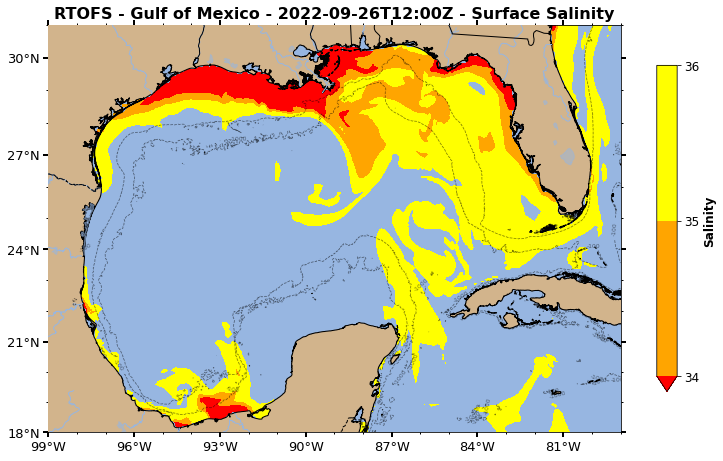

In [19]:
# Salinity, Red: < 34, Orange: 34-35, Yellow: 35-36,........ 
salinity = [34, 35, 36]

fig, ax = cplt.create(conf['extent'], bathymetry=True, isobaths=(-1000, -100), figsize=figsize)
h = ax.contourf(tds.lon, tds.lat, tds.salinity, levels=salinity, transform=proj, colors=['red', 'orange', 'yellow'], extend='min')
cb = fig.colorbar(h, ax=ax, orientation="vertical", shrink=0.8, aspect=20*0.8)
cb.ax.tick_params(labelsize=12)
cb.set_label(f'Salinity', fontsize=12, fontweight="bold")
plt.title(f'RTOFS - Gulf of Mexico - {tstr} - Surface Salinity', fontweight='bold', fontsize=16)
plt.savefig('/Users/mikesmith/Documents/sss.png', dpi=150, bbox_inches='tight', pad_inches=0.1, facecolor='white')


In [ ]:
# temperature.. red: > 30, Orange: 28-30, Yellow: 26-28, 
temperature = [26, 28, 30]

fig, ax = cplt.create(conf['extent'], bathymetry=True, isobaths=(-1000, -100), figsize=figsize)
h = ax.contourf(tds.lon, tds.lat, tds.temperature, levels=temperature, transform=proj, colors=['yellow', 'orange', 'red'], extend='max')
cb = fig.colorbar(h, ax=ax, orientation="vertical", shrink=0.9, aspect=20*0.9)
cb.ax.tick_params(labelsize=12)
cb.set_label(f'Temperature (°C)', fontsize=12, fontweight="bold")
plt.title('RTOFS - Gulf of Mexico - Surface Temperature', fontweight='bold', fontsize=16)
plt.savefig('/Users/mikesmith/Documents/sst.png', dpi=150, bbox_inches='tight', pad_inches=0.1, facecolor='white')


In [ ]:
# ocean heat content: red - > 100, orange: 75-100, yellow: 50-75
ohc = [50, 75, 100]

fig, ax = cplt.create(conf['extent'], bathymetry=True, isobaths=(-1000, -100), figsize=figsize)
h = ax.contourf(tds.lon, tds.lat, tds.ohc, levels=ohc, transform=proj, colors=['yellow', 'orange', 'red'], extend='max')
cb = fig.colorbar(h, ax=ax, orientation="vertical", shrink=0.9, aspect=20*0.9)
cb.ax.tick_params(labelsize=12)
cb.set_label(f'OHC (kJ/cm^2)', fontsize=12, fontweight="bold")
plt.title('RTOFS - Gulf of Mexico - Ocean Heat Content', fontweight='bold', fontsize=18)
